This notebook contains:
- training and validation of a model that predicts sun-induced fluorescence (SIF) from climate variables (ERA5)
- explanation of the contribution of the climate variables to the predicted SIF using SHAP (SHapley Additive exPlanations)

Adrià Descals - a.descals@creaf.uab.cat / CREAF - Centre de Recerca Ecològica i Aplicacions Forestals

In [ ]:
!pip install shap
!pip install geopandas
!pip install interpret

In [2]:
import numpy as np
import scipy

import sklearn
import graphviz
import interpret.glassbox
import pandas as pd
import shap
import matplotlib.pyplot as plt
import xgboost
from scipy.stats import gaussian_kde
from datetime import datetime
from tqdm import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from osgeo import gdal

In [3]:
import random
random.seed(12345)

# Load data

In [4]:
dfB2 = pd.read_csv('https://raw.githubusercontent.com/adriadescals/SHAP_PHENO_SIF/master/BELMANIP2_RESOLVE-ECOREGIONS_MCD12Q1v6.csv')
dfALL = pd.read_csv('https://raw.githubusercontent.com/adriadescals/SHAP_PHENO_SIF/master/BELMANIP2_SIF_ERA5.csv')

In [5]:
dfALL["BIO"] = dfALL["SIF_Corr_743"] # change SIF_743 (default) to SIF_Corr_743

dfSorted = dfALL.sort_values(by=['randomNum'])
dfALL.shape

(276338, 16)

In [6]:
dfALL.head()

,site,igbp,ecoregion,DOYmatlab,YY,DoY,TA,SW,VPD,SIF_Corr_743,DIST,VZA,SZA,cloud_fraction,randomNum,BIO
0,1,7,8,737181,2018,121,9.906626,118.974311,0.712762,0.021323,52,59,60,51,210747,0.021323
1,1,7,8,737182,2018,122,9.735122,116.585260,0.682091,-0.081466,2,32,68,72,221716,-0.081466
2,1,7,8,737183,2018,123,10.017063,111.091898,0.658218,-0.114965,1,7,66,0,166675,-0.114965
3,1,7,8,737184,2018,124,10.664160,108.642606,0.665020,0.125059,1,19,65,0,72009,0.125059
4,1,7,8,737185,2018,125,11.733558,106.428243,0.723411,0.057007,2,42,64,7,14295,0.057007


In [7]:
mask = (dfSorted["cloud_fraction"]<50) & (dfSorted["DIST"]<5)
dfSorted = dfSorted.loc[mask]
dfSorted.shape

mask = (dfALL["cloud_fraction"]<50) & (dfALL["DIST"]<5)
df = dfALL.loc[mask]

# trainSize = 100000
dfSize = dfSorted.shape
trainSize = int(np.round(dfSize[0]*0.75))


# Train/Test split

In [8]:
bandNames = ["TA", "SW", "VPD"]

In [9]:
X = dfSorted[bandNames]
y = dfSorted[["BIO"]]
igbp = dfSorted[["igbp"]]
sites = dfSorted[["site"]]

In [10]:
Xtrain = X[:trainSize] # 
ytrain = y[:trainSize]
Xtest = X[trainSize:]
ytest = y[trainSize:]
igbptest = igbp[trainSize:]
X100 = shap.utils.sample(Xtest, 10000)
y100 = shap.utils.sample(ytest, 10000)
igbp100 = shap.utils.sample(igbptest, 10000)

In [11]:
print(Xtrain.shape)
print(Xtest.shape)
print(X100.shape)

(105727, 3)
(35242, 3)
(10000, 3)


# Train model

In [12]:
# Train XGBOOST model 
model_xgb0 = xgboost.XGBRegressor(subsample= 0.7, n_estimators= 300, max_depth= 3, learning_rate= 0.05, colsample_bytree= 0.8, colsample_bylevel= 0.4, seed = 12345).fit(Xtrain, ytrain)
modelID = int(datetime.timestamp(datetime.now()))

[14:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Validation per biome

In [13]:
igbpSelected = [1,3,4,5,6,7,8,9,10]
labelsIGBP = ["ENF","EBF", "DNF","DBF","MX","CSH","OSH","WSA","SAV","GRA","WET","CRO","URB","CNM","SNO","BAR","WAT"]

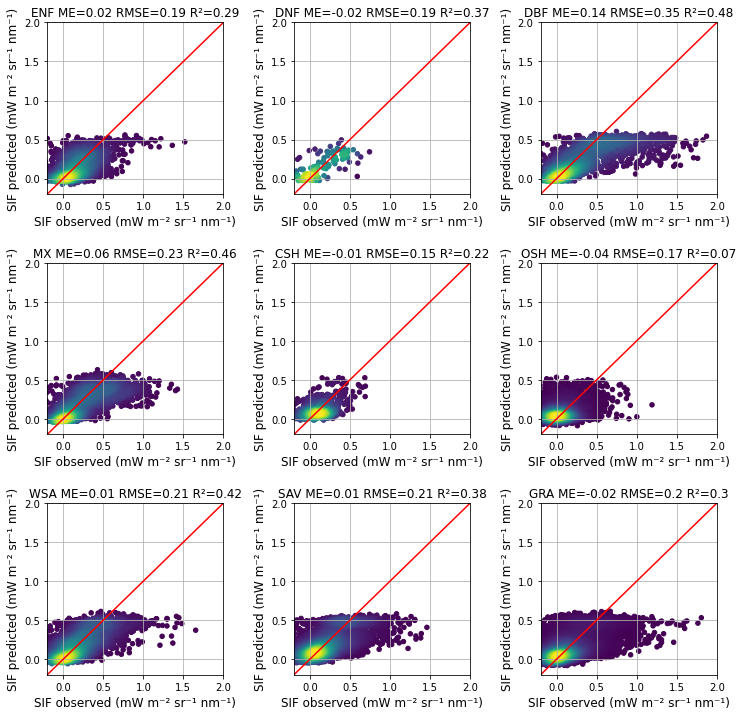

In [14]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# data
xall = ytest.to_numpy().T[0]
yall = model_xgb0.predict(Xtest)

for ii in range(0, 9):
  
  maskIGBP = (igbptest == igbpSelected[ii]).to_numpy().T[0]
  xg = xall[maskIGBP]
  yg = yall[maskIGBP]


  # Calculate the point density
  xy = np.vstack([xg,yg])
  zg = gaussian_kde(xy)(xy)

  # Sort the points by density, so that the densest points are plotted last
  idx = zg.argsort()
  xg, yg, zg = xg[idx], yg[idx], zg[idx]

  correlation_matrix = np.corrcoef(xg, yg)
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2

  titlesubplot = labelsIGBP[igbpSelected[ii]-1]+' ME='+str(round(np.mean(xg-yg), 2))+' RMSE='+str(round(mean_squared_error(xg, yg, squared=False), 2))+' R\u00b2='+str(round(r_squared, 2))

  ax = fig.add_subplot(3, 3, ii+1)
  plt.grid()
  ax.scatter(xg, yg, c=zg, s=20)
  plt.xlim([-0.2, 2])
  plt.ylim([-0.2, 2])
  plt.plot([-5, 5], [-5, 5], '-r')  
  plt.title(titlesubplot)
  plt.xlabel('SIF observed (mW m\u207b\u00b2 sr\u207b\u00b9 nm\u207b\u00b9)', fontsize=12)
  plt.ylabel('SIF predicted (mW m\u207b\u00b2 sr\u207b\u00b9 nm\u207b\u00b9)', fontsize=12)



# Visualize sites

In [15]:
isite = 189 # select site

tblSite = dfALL[dfALL.site==isite]

Xsite = tblSite[bandNames]
ysite = tblSite[["BIO"]]

ypred = model_xgb0.predict(Xsite)

explainer_xgb = shap.Explainer(model_xgb0.predict, Xtrain)
shap_values_xgb_site = explainer_xgb(Xsite)

DOYmatlabsite = tblSite[["DOYmatlab"]].to_numpy().T[0]
DOYpython = pd.to_datetime(DOYmatlabsite-719529, unit='D')

igbpSite = labelsIGBP[np.unique(tblSite[["igbp"]].to_numpy())[0]-1]
siteLat = dfB2.Latitude[dfB2.ID==isite].to_numpy()[0]
siteLon = dfB2.Longitude[dfB2.ID==isite].to_numpy()[0]  


Exact explainer: 1187it [00:21, 34.73it/s]                          


(array([736876., 737060., 737241., 737425., 737607., 737791., 737972.,
        738156.]),
 <a list of 8 Text major ticklabel objects>)

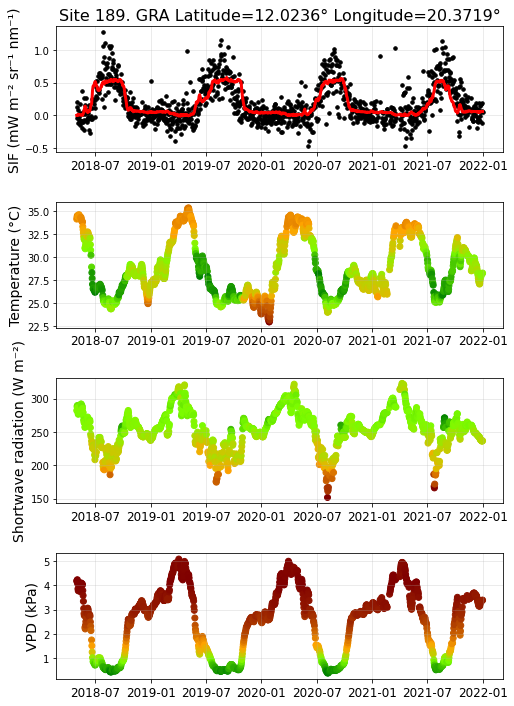

In [16]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colorlist=["maroon","orange","lawngreen","green"]
customCmap = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)
# customCmap = ListedColormap(["blue","green"])

fig = plt.figure(figsize=(8, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(4, 1, 1)
plt.grid(alpha=0.3)
ax.plot(DOYpython,tblSite.BIO,'.k', markersize=7)
ax.plot(DOYpython,ypred,'-r', lineWidth=3)
plt.rcParams['figure.figsize'] = [12,3]
plt.title('Site '+str(isite)+'. '+igbpSite+' Latitude='+str(round(siteLat,4))+'° Longitude='+str(round(siteLon,4))+'°',fontSize=16)
plt.ylabel('SIF (mW m\u207b\u00b2 sr\u207b\u00b9 nm\u207b\u00b9)',fontSize=14)
plt.xticks(fontsize=12)

ax = fig.add_subplot(4, 1, 2)
plt.grid(alpha=0.3)
colors = shap_values_xgb_site.values[:tblSite.BIO.size,0]
ax.scatter(DOYpython, Xsite[['TA']], c=colors, cmap= customCmap, alpha=1)
plt.rcParams['figure.figsize'] = [12,3]
plt.ylabel('Temperature (°C)',fontSize=14)
plt.xticks(fontsize=12)

ax = fig.add_subplot(4, 1, 3)
plt.grid(alpha=0.3)
colors = shap_values_xgb_site.values[:tblSite.BIO.size,1]
ax.scatter(DOYpython, Xsite[['SW']], c=colors, cmap= customCmap, alpha=1)
plt.rcParams['figure.figsize'] = [12,3]
plt.ylabel('Shortwave radiation (W m\u207b\u00b2)',fontSize=14)
plt.xticks(fontsize=12)

ax = fig.add_subplot(4, 1, 4)
plt.grid(alpha=0.3)
colors = shap_values_xgb_site.values[:tblSite.BIO.size,2]
ax.scatter(DOYpython, Xsite[['VPD']], c=colors, cmap= customCmap, alpha=1)
plt.rcParams['figure.figsize'] = [12,3]
plt.ylabel('VPD (kPa)',fontSize=14)
plt.xticks(fontsize=12)
